In [1]:
# IBM Capstone Project: The Battle of Neighbourhoods 

#Analysis of London Boroughs for Real Estate Investment

#Let's import and install some packages that we might need 

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
# uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import requests # library to handle requests

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values



Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  openssl                                 1.1.1g-h516909a_0 --> 1.1.1g-h516909a_1



openssl-1.1.1g       | 2.1 MB    | #####

In [2]:
# Firstly we import  the London Borough-based crime csv dataset and store it in a pandas dataframe

path = r'https://data.london.gov.uk/download/recorded_crime_summary/d2e9ccfc-a054-41e3-89fb-53c2bc3ed87a/MPS%20Borough%20Level%20Crime%20%28most%20recent%2024%20months%29.csv'

c = pd.read_csv(path)

crime = pd.DataFrame(c)

crime.head()


,MajorText,MinorText,LookUp_BoroughName,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006
0,Arson and Criminal Damage,Arson,Barking and Dagenham,6,5,3,8,5,1,5,2,5,5,11,3,5,3,6,9,8,6,4,5,6,2,2,4
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,127,101,107,132,105,88,97,127,138,130,140,113,134,118,109,109,97,121,97,103,107,80,86,121
2,Burglary,Burglary - Business and Community,Barking and Dagenham,30,18,33,32,39,33,45,24,29,27,21,27,31,35,37,30,30,25,31,17,28,29,16,16
3,Burglary,Burglary - Residential,Barking and Dagenham,94,84,99,94,106,164,114,107,99,96,114,96,71,67,80,97,114,130,116,123,97,57,41,63
4,Drug Offences,Drug Trafficking,Barking and Dagenham,8,7,10,7,7,4,5,2,6,5,9,6,11,7,7,8,13,3,14,5,6,12,12,7


In [3]:
# As originally organized, the data cannot really be used for our purpose. 
#Thus, let's manipulate the data in order to make it suitable for our analysis.

crime.drop(['MajorText', 'MinorText'], axis=1, inplace=True) # we drop not relevant variables, in this case the crime labels
                                                             # since we are interested in the phenomenon as a whole 

crime.columns = list(map(str, crime.columns))   # for sake of consistency, let's also make all column labels
                                                #of type string
    
crime.rename(columns={'LookUp_BoroughName':'Borough'}, inplace=True) #let's rename the variable Borough for consistency 

crime.set_index('Borough', inplace=True) # we set the variable Borough ad index of the dataframe


crime.head()

,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006
Borough,,,,,,,,,,,,,,,,,,,,,,,,
Barking and Dagenham,6,5,3,8,5,1,5,2,5,5,11,3,5,3,6,9,8,6,4,5,6,2,2,4
Barking and Dagenham,127,101,107,132,105,88,97,127,138,130,140,113,134,118,109,109,97,121,97,103,107,80,86,121
Barking and Dagenham,30,18,33,32,39,33,45,24,29,27,21,27,31,35,37,30,30,25,31,17,28,29,16,16
Barking and Dagenham,94,84,99,94,106,164,114,107,99,96,114,96,71,67,80,97,114,130,116,123,97,57,41,63
Barking and Dagenham,8,7,10,7,7,4,5,2,6,5,9,6,11,7,7,8,13,3,14,5,6,12,12,7


In [4]:
#let's now group the sum of the crimes registered per month per each Borough 
crime = crime.groupby(level="Borough").sum()

crime.head()

,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006
Borough,,,,,,,,,,,,,,,,,,,,,,,,
Barking and Dagenham,1612,1460,1469,1584,1562,1544,1581,1576,1711,1681,1823,1687,1823,1546,1646,1790,1658,1653,1670,1581,1792,1270,1444,1625
Barnet,2368,2244,2264,2550,2561,2421,2412,2545,2844,2550,2562,2736,2829,2417,2611,2629,2830,2606,2640,2590,2298,1659,1979,2068
Bexley,1238,1243,1263,1341,1412,1468,1543,1348,1436,1488,1604,1473,1534,1530,1491,1673,1537,1402,1623,1461,1283,902,1218,1181
Brent,2750,2510,2556,2728,2732,2388,2491,2372,2671,2445,2572,2579,2676,2474,2561,2661,2507,2423,2513,2382,2266,2025,2242,2397
Bromley,1927,1854,1941,1970,1989,1992,2000,1956,2109,1967,2115,2012,2200,2101,2118,2226,2294,2089,2147,2074,1765,1443,1638,1685


In [5]:
# we create a variable that sums all the crimes committed over the observation period (24 months)

# add total column
crime['Mean'] = crime.mean(axis=1)
crime.head()

#Finally let's organize the dataframe based on the Mean, that is we organize from the Borough with the highest crime average rate per month
# in the last 24 months to the one with the highest  

crime = crime.sort_values(by='Mean', ascending=False)

crime.head()

crime.to_html("crime1.html")

In [6]:
crime2 = crime[["Mean"]] #new dataframe with just the mean variable
crime2 = crime2.drop('London Heathrow and London City Airports',axis=0) #we drop 'London Heatrow and London City Airports' 
                                                                         #which is not considered a borough according
                                                                          #to other databases
crime2.to_html("crime2.html")

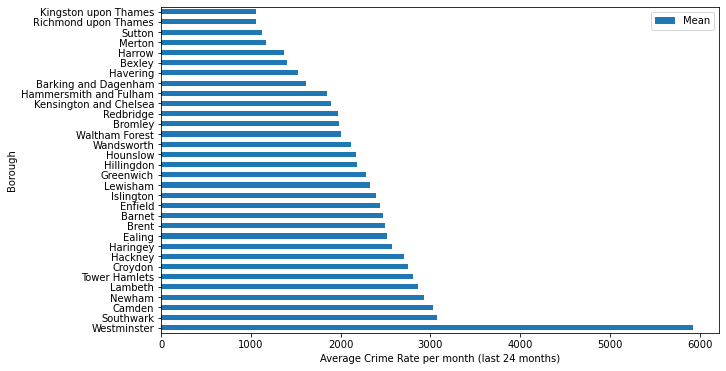

In [7]:
#Here we have a descending list of london Boroughs based on the average crime rate over the most recent 24 months of observations
# For the sake of rovide the informations to the client in the clearest and most impactful possible way, let's create two 
# visualization of the data, a bar chart and a cloropeth map 

#1 BAR CHART
import matplotlib as mpl
import matplotlib.pyplot as plt

#Now let's plot an horizontal bar chart with the plot function 

crime2.plot(kind='barh', figsize=(10, 6), rot=0) 

plt.xlabel('Average Crime Rate per month (last 24 months)')

plt.show()



In [8]:
#2 CHOROPLETH MAP 

!wget --quiet https://skgrange.github.io/www/data/london_boroughs.json  -O london_boroughs.json
    

london_boroughs = r'london_boroughs.json' # geojson file

In [9]:
crime2.reset_index(level=0, inplace=True) #to remove boroughs as index

In [10]:
# Let's create a plain London  map

!conda install -c conda-forge folium=0.5.0 --yes
import folium

London_map = folium.Map(location=[51.5074, -0.1278], zoom_start=11,tiles='Mapbox Bright')



Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-3.0           |   py36h45558ae_0         640 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    pandas-1.1.0               |   py36h831f99a_0        10.5 MB  conda-forge
    pysocks-1.7.1              |   py36h9f0ad1d_1          27 KB  conda-

In [39]:
# Let's create a plain London  map

London_map = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

In [40]:
#Let's now create the choropleth map 
London_map.choropleth(
    geo_data=london_boroughs,
    data=crime2,
    columns=['Borough','Mean'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.4,
    highlight= True,
    legend_name='Monthly Average Crime Rate in London Boroughs')


London_map.save('Lonodn3.html')

London_map


In [13]:
# Now we have a clear visualization of the average crime rate per month in London boroughs.Let's pick the 3boroughs with less crime, that is:
# -Kingston upon Thames
# -Richmond upon Thames

# From this 3 we will then pick the two Boroughs for real estate investment after having performed a nearby venues analysis

In [14]:
#FOUTHSQUARE API: VENUES RECCOMANDATIONS IN THE CHOSEN BOROUGHS 

#I start by giving the fourthsquare api credentials for the search
CLIENT_ID = 'VXMDG1QQRSYHFEVNZEMNLM1W11OYBHCRKPG0ZUDKA0CUOO5B' #  Foursquare ID
CLIENT_SECRET = 'NR0P1NLMEK3DKHB3S2EGHN2RTL1BNXIXMVAOAYXFQE3YYACQ' #  Foursquare Secret
VERSION = '20180604'
LIMIT = 2
print('Credential:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credential:
CLIENT_ID: VXMDG1QQRSYHFEVNZEMNLM1W11OYBHCRKPG0ZUDKA0CUOO5B
CLIENT_SECRET:NR0P1NLMEK3DKHB3S2EGHN2RTL1BNXIXMVAOAYXFQE3YYACQ


In [15]:
borough = 'Kingston upon Thames'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(borough)
lat= location.latitude
long = location.longitude


borough2 = 'Richmond upon Thames'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(borough2)
lat2 = location.latitude
long2 = location.longitude

borough3 = 'Sutton, London'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(borough3)
lat3 = location.latitude
long3 = location.longitude

print("Kingston", lat, long , "Richmond", lat2, long2, "Sutton", lat3, long3)

Kingston 51.4096275 -0.3062621 Richmond 51.44037225 -0.3057195504470487 Sutton 51.3575114 -0.173640122600872


In [16]:
#let's now search for the nearby venues.As the main categories that we will use for judging 
categoryid= '4d4b7104d754a06370d81259' # Arts and Entertainment category id 
categoryid2= '4d4b7105d754a06374d81259' #Food category id 
categoryid3= '4d4b7105d754a06377d81259' # Outdoor and recreation category id
categoryid4= '4d4b7105d754a06378d81259' #shop and service category id
radius = 1500





In [17]:
#Let's define the corresponding urlS for venues reccomandation 
#'Kingston upon Thames'
url1 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, VERSION,categoryid, radius, LIMIT)
url2 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, VERSION,categoryid2 , radius, LIMIT)
url3 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, VERSION,categoryid3 , radius, LIMIT)
url4 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, VERSION,categoryid4 , radius, LIMIT)

#'Richmond upon Thames'
url5 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat2, long2, VERSION,categoryid , radius, LIMIT)
url6 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat2, long2, VERSION,categoryid2 , radius, LIMIT)
url7 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat2, long2, VERSION,categoryid3 , radius, LIMIT)
url8 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat2, long2, VERSION,categoryid4, radius, LIMIT)

#Sutton
url9 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat3, long3, VERSION,categoryid, radius, LIMIT)
url10 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat3, long3, VERSION,categoryid2, radius, LIMIT)
url11 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat3, long3, VERSION,categoryid3, radius, LIMIT)
url12 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat3, long3, VERSION,categoryid4, radius, LIMIT)

In [18]:
#We now make 12 calls to the API to get json dictionaries with the information about hte reccomended venues 
#'Kingston upon Thames'
results1 = requests.get(url1).json()
results2 = requests.get(url2).json()
results3 = requests.get(url3).json()
results4 = requests.get(url4).json()

#'Richmond upon Thames'
results5 = requests.get(url5).json()
results6 = requests.get(url6).json()
results7 = requests.get(url7).json()
results8 = requests.get(url8).json()

#Sutton
results9 = requests.get(url9).json()
results10 = requests.get(url10).json()
results11 = requests.get(url11).json()
results12 = requests.get(url12).json()


In [19]:
#Let's exctract from the json file the dictionary section containing the name and related information about the venues

#'Kingston upon Thames'
venues1 = results1['response']["groups"][0]['items']
venues2 = results2['response']["groups"][0]['items']
venues3 = results3['response']["groups"][0]['items']
venues4 = results4['response']["groups"][0]['items']


#'Richmond upon Thames'
venues5 = results5['response']["groups"][0]['items']
venues6 = results6['response']["groups"][0]['items']
venues7 = results7['response']["groups"][0]['items']
venues8 = results8['response']["groups"][0]['items']

#Sutton
venues9 = results9['response']["groups"][0]['items']
venues10 = results10['response']["groups"][0]['items']
venues11 = results11['response']["groups"][0]['items']
venues12 = results12['response']["groups"][0]['items']

In [20]:
#Finally we convert the dictionaries in pandas dataframe

dataframe1 = pd.json_normalize(venues1)

dataframe1 = dataframe1[['venue.name', 'venue.location.lat', 'venue.location.lng']]
dataframe1


,venue.name,venue.location.lat,venue.location.lng
0,Rose Theatre,51.408557,-0.307327
1,The Fighting Cocks,51.410660,-0.298287


In [21]:
dataframe2 = pd.json_normalize(venues2)
dataframe2.head()

dataframe2 = dataframe2[['venue.name', 'venue.location.lat', 'venue.location.lng']]
dataframe2

,venue.name,venue.location.lat,venue.location.lng
0,Stein's,51.407100,-0.307940
1,Fortunella,51.409257,-0.305709


In [22]:
dataframe3 = pd.json_normalize(venues3)
dataframe3.head()

dataframe3 = dataframe3[['venue.name', 'venue.location.lat', 'venue.location.lng']]
dataframe3

,venue.name,venue.location.lat,venue.location.lng
0,David Lloyd,51.411828,-0.299382
1,Kingston Town Centre,51.410639,-0.301996


In [23]:
dataframe4 = pd.json_normalize(venues4)
dataframe4.head()

dataframe4 = dataframe4[['venue.name', 'venue.location.lat', 'venue.location.lng']]
dataframe4

,venue.name,venue.location.lat,venue.location.lng
0,Kingston Market Place,51.40960,-0.306265
1,Banquet Records,51.40908,-0.303382


In [24]:
dataframe5 = pd.json_normalize(venues5)


dataframe5 = dataframe5[['venue.name', 'venue.location.lat', 'venue.location.lng']]
dataframe5

,venue.name,venue.location.lat,venue.location.lng
0,Orleans House Gallery,51.447247,-0.319260
1,RSPCA Statue,51.450063,-0.301386


In [25]:
dataframe6 = pd.json_normalize(venues6)


dataframe6 = dataframe6[['venue.name', 'venue.location.lat', 'venue.location.lng']]
dataframe6

,venue.name,venue.location.lat,venue.location.lng
0,Petersham Nurseries Cafe,51.447032,-0.302446
1,Hansel & Pretzel,51.438519,-0.313489


In [26]:
dataframe7 = pd.json_normalize(venues7)
dataframe7.head()

dataframe7 = dataframe7[['venue.name', 'venue.location.lat', 'venue.location.lng']]
dataframe7

,venue.name,venue.location.lat,venue.location.lng
0,King Henry's Mound,51.444925,-0.294784
1,Marble Hill Park,51.450022,-0.312746


In [27]:
dataframe8 = pd.json_normalize(venues8)
dataframe8.head()

dataframe8 = dataframe8[['venue.name', 'venue.location.lat', 'venue.location.lng']]
dataframe8

,venue.name,venue.location.lat,venue.location.lng
0,Petersham Nurseries,51.447148,-0.302453
1,Stephen Charles Landscapes,51.441650,-0.304919


In [28]:
dataframe9 = pd.json_normalize(venues9)
dataframe9.head()

dataframe9 = dataframe9[['venue.name', 'venue.location.lat', 'venue.location.lng']]
dataframe9

,venue.name,venue.location.lat,venue.location.lng
0,Little Holland House,51.355093,-0.170723
1,Soundbox,51.364912,-0.186464


In [29]:
dataframe10 = pd.json_normalize(venues10)
dataframe10.head()

dataframe10 = dataframe10[['venue.name', 'venue.location.lat', 'venue.location.lng']]
dataframe10

,venue.name,venue.location.lat,venue.location.lng
0,Vinoteca Italiana,51.357070,-0.170221
1,Nando's,51.360126,-0.191837


In [30]:
dataframe11 = pd.json_normalize(venues11)
dataframe11.head()

dataframe11 = dataframe11[['venue.name', 'venue.location.lat', 'venue.location.lng']]
dataframe11

,venue.name,venue.location.lat,venue.location.lng
0,Carshalton Ponds,51.365656,-0.163690
1,Manor Park,51.362751,-0.190394


In [31]:
dataframe12 = pd.json_normalize(venues12)
dataframe12.head()

dataframe12 = dataframe12[['venue.name', 'venue.location.lat', 'venue.location.lng']]
dataframe12

,venue.name,venue.location.lat,venue.location.lng
0,Co-op Food,51.356905,-0.173753
1,Waterstones,51.362160,-0.192780


In [42]:
#Let's create a joint dataframes by concatenating the previous ones


f = [dataframe1,dataframe2,dataframe3,dataframe4,dataframe5,dataframe6,dataframe7,dataframe8,dataframe9,dataframe10,dataframe11,dataframe12]

frames  = pd.concat(f,ignore_index= True)

#And rename for comodity the columns
frames = frames.rename(columns={"venue.name": "name","venue.location.lat":"lat","venue.location.lng":"lng"})


frames.to_html('concdat.html')
frames

,name,lat,lng
0,Rose Theatre,51.408557,-0.307327
1,The Fighting Cocks,51.410660,-0.298287
2,Stein's,51.407100,-0.307940
3,Fortunella,51.409257,-0.305709
4,David Lloyd,51.411828,-0.299382
5,Kingston Town Centre,51.410639,-0.301996
6,Kingston Market Place,51.409600,-0.306265
7,Banquet Records,51.409080,-0.303382
8,Orleans House Gallery,51.447247,-0.319260
9,RSPCA Statue,51.450063,-0.301386


In [33]:
#Finally, we can create a map with all the suggested venues.First, we instatiate a plein map of london 
london_map =folium.Map(location=[51.5074, -0.1278], zoom_start=11)

#Then, in order to create markers on the venues, we iterate the feature foliu.Marker through all the dataframe

for lat,lng,labels in zip(frames.lat, frames.lng, frames.name):
        folium.Marker(location=[lat,lng]).add_to(london_map)


        
london_map